<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.3
IPython 6.1.0

numpy 1.13.3
scipy 0.19.1
pandas 0.20.3
matplotlib 2.1.0
statsmodels 0.8.0
sklearn 0.19.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.13.0-1012-gcp
machine    : x86_64
processor  : x86_64
CPU cores  : 6
interpreter: 64bit
Git hash   : 95ac72b927b897aae041380e6434997b22894b99


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'data'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

In [5]:
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [7]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
%%time
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
knn.fit(X_train, y_train)
knn_prediction = knn.predict(X_valid)

CPU times: user 1.19 s, sys: 1.27 s, total: 2.47 s
Wall time: 3.36 s


**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [51]:
%%time
cv_score_train = np.mean(cross_val_score(knn, X_train, y_train, n_jobs=-1, cv=skf))
val_score = accuracy_score(y_valid, knn_prediction)

CPU times: user 85.8 ms, sys: 76.5 ms, total: 162 ms
Wall time: 1.25 s


In [52]:
print(round(cv_score_train,3),' ', round(val_score, 3))

0.565   0.584


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=-1, oob_score=True).fit(X_train, y_train)
forest_prediction = forest.predict(X_valid)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [18]:
oob_score_train = forest.oob_score_
forest_valid_score = accuracy_score(y_valid, forest_prediction)

In [19]:
oob_score_train, forest_valid_score

(0.7172322698638488, 0.73121592794501067)

In [20]:
answer = str(round(oob_score_train, 3))+" "+str(round(forest_valid_score, 3))

with open("answer4_2.txt", "w") as text_file:
    text_file.write(answer)

In [21]:
!cat answer4_2.txt

0.717 0.731

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [11]:
logit = LogisticRegression(random_state=17).fit(X_train, y_train)
logit_precit = logit.predict(X_valid)

In [12]:
cv_score_train = np.mean(cross_val_score(logit, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=skf))
cv_score_valid = np.mean(cross_val_score(logit, X_valid, y_valid, scoring='accuracy', n_jobs=-1, cv=skf))
print(round(cv_score_train,3), " ", round(cv_score_valid, 3))

0.761   0.725


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [25]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, 
                                            n_jobs=-1, multi_class='multinomial', 
                                            random_state=17, scoring='accuracy').fit(X_train, y_train)

CPU times: user 4.93 s, sys: 178 ms, total: 5.11 s
Wall time: 22.1 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [26]:
logit_mean_cv_scores1 = np.mean(logit_grid_searcher1.scores_[1], axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [27]:
print('Лучшее значение доли правильных ответов - {}\
\nСоответствующее значение С - {}'.format(round(np.max(logit_mean_cv_scores1),4), 
                          logit_grid_searcher1.Cs_[np.argmax(logit_mean_cv_scores1)]))

Лучшее значение доли правильных ответов - 0.7592
Соответствующее значение С - 1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [13]:
logit_c_values1

NameError: name 'logit_c_values1' is not defined

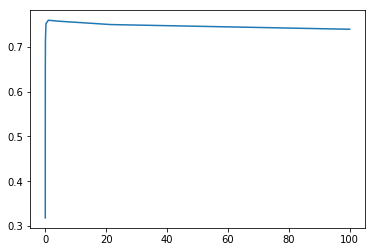

In [29]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [14]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, 
                                            n_jobs=-1, multi_class='multinomial', 
                                            random_state=17, scoring='accuracy')
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 5.62 s, sys: 163 ms, total: 5.78 s
Wall time: 57.5 s


In [15]:
log_gs2_prediction = logit_grid_searcher2.predict(X_valid)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [16]:
logit_mean_cv_scores2 = np.mean(logit_grid_searcher2.scores_[1], axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [17]:
print('Лучшее значение доли правильных ответов - {}\
\nСоответствующее значение С - {}'.format(round(np.max(logit_mean_cv_scores2),4), 
                          logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]))

Лучшее значение доли правильных ответов - 0.7589
Соответствующее значение С - 0.4631578947368421


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

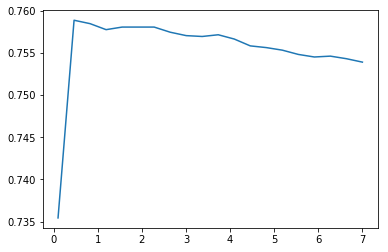

In [18]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [19]:
logit_cv_acc = accuracy_score(y_valid, log_gs2_prediction)
print(logit_cv_acc)

0.774828158331


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [36]:
%%time
cv_score_train = np.mean(cross_val_score(logit_grid_searcher2, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=skf))
valid_score = accuracy_score(y_valid, log_gs2_prediction)
print(round(cv_score_train,3), " ", round(valid_score, 3))

0.758   0.775
CPU times: user 219 ms, sys: 100 ms, total: 320 ms
Wall time: 2min 43s


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [20]:
from sklearn.svm import LinearSVC

In [21]:
svm = LinearSVC(random_state=17).fit(X_train, y_train)
svm_predict = svm.predict(X_valid)

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [22]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 4.33 s, sys: 63.8 ms, total: 4.39 s
Wall time: 19.1 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [23]:
svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_

(0.68482015850436906, {'C': 7777.7778000000008})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

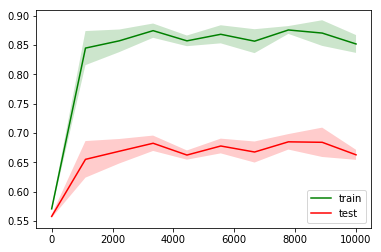

In [24]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [64]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, n_jobs=-1, cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 858 ms, sys: 84.2 ms, total: 942 ms
Wall time: 24.5 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [65]:
svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_

(0.76468197520829095, {'C': 0.10434482758620689})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

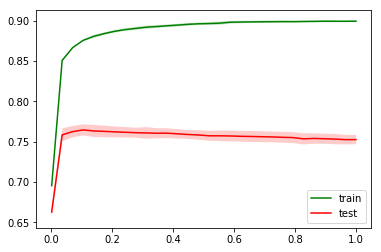

In [66]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [67]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))
print(svm_cv_acc)

0.780753733112


**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [68]:
%%time
cv_score_train_svm = np.mean(cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, n_jobs=-1, cv=skf))
valid_score_svm = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))

CPU times: user 107 ms, sys: 56.1 ms, total: 163 ms
Wall time: 653 ms


In [69]:
print(round(cv_score_train_svm, 3), " ", round(valid_score_svm, 3))

0.765   0.781


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [70]:
import timeit
from datetime import datetime

In [71]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    start = timeit.default_timer()
    
    #Open the pickle files and save the data to X and y:
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl).astype(int)
    
    #Split the data into train and validation:
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    
    estimator.fit(X_train, y_train)
    prediction = estimator.predict(X_valid)
    cv_score = np.mean(cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1))
    acc_score = accuracy_score(y_valid, prediction)
    
    end = timeit.default_timer()
    
    time = end - start
    
    return cv_score, acc_score, '%d:%02d'%divmod(time, 60)

**Убедитесь, что функция работает.**

In [72]:
%%time
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), cv=skf, random_state=17, test_size=0.3)

CPU times: user 770 ms, sys: 95.9 ms, total: 865 ms
Wall time: 1.35 s


(0.76468532445509807, 0.78075373311211183, '0:01')

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [73]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl

In [74]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        print(session_length, window_size, model_assessment(estimator, path_to_X_pkl, path_to_y_pkl,
                                                            skf, random_state=17, test_size=0.3))

15 10 (0.82382149552781048, 0.84048352690210948, '0:02')
10 10 (0.76468532445509807, 0.78075373311211183, '0:01')
15 7 (0.84794037698440983, 0.85432221669155473, '0:02')
10 7 (0.79701614637346518, 0.80736684917869583, '0:01')
7 7 (0.75298911148303416, 0.76173884187821472, '0:01')
15 5 (0.86800137255434695, 0.87529634898055952, '0:04')
10 5 (0.81592472053180387, 0.82456140350877194, '0:02')
7 5 (0.77405867456322597, 0.78532479848269321, '0:01')
5 5 (0.72528306503988282, 0.73624940730203892, '0:01')
CPU times: user 11.6 s, sys: 696 ms, total: 12.3 s
Wall time: 19.7 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [75]:
%%time
scores = model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w5.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users_s15_w5.pkl'), cv=skf, random_state=17, test_size=0.3)

print(round(scores[0], 3), round(scores[1], 3))

0.868 0.875
CPU times: user 2.71 s, sys: 100 ms, total: 2.81 s
Wall time: 4.48 s


**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [95]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
        print(session_length, window_size, model_assessment(estimator, path_to_X_pkl, path_to_y_pkl,
                                                            skf, random_state=17, test_size=0.3))

5 5 (0.40966616772947401, 0.42267727648805176, 278.23)
7 7 (0.43686797191901516, 0.45415062847021154, 236.84)
10 10 (0.46131133117144474, 0.48447915146207365, 196.53)
CPU times: user 7min 13s, sys: 828 ms, total: 7min 14s
Wall time: 11min 51s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [76]:
%%time
scores = model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_150users_s10_w10.pkl'),
        os.path.join(PATH_TO_DATA, 'y_150users_s10_w10.pkl'), cv=skf, random_state=17, test_size=0.3)

print(round(scores[0], 3), round(scores[1], 3))

0.461 0.484
CPU times: user 2min 30s, sys: 290 ms, total: 2min 30s
Wall time: 3min 44s


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [77]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [78]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)
y_train_150 = y_train_150.astype(int)
y_valid_150 = y_valid_150.astype(int)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [46]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]], multi_class='ovr', n_jobs=-1, random_state=17)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 8min 58s, sys: 7.05 s, total: 9min 5s
Wall time: 9min 4s


In [47]:
logit_cv_150users.scores_[1]

array([[ 0.99594054],
       [ 0.99605831],
       [ 0.9955518 ]])

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [48]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, np.mean(logit_cv_150users.scores_[user_id])))

User 1, CV score: 0.995850217686121
User 2, CV score: 0.9962154692488628
User 3, CV score: 0.9951310537804167
User 4, CV score: 0.9915759824185644
User 5, CV score: 0.989886456818156
User 6, CV score: 0.9945366562081962
User 7, CV score: 0.9935672094050271
User 8, CV score: 0.9860393314979725
User 9, CV score: 0.9980607063671277
User 10, CV score: 0.9948599899870656
User 11, CV score: 0.9944221631139541
User 12, CV score: 0.9936091179828602
User 13, CV score: 0.9969347547292645
User 14, CV score: 0.9949642340422806
User 15, CV score: 0.9963612170153343
User 16, CV score: 0.9963509868624326
User 17, CV score: 0.9905331098557655
User 18, CV score: 0.9943387038465749
User 19, CV score: 0.9947556519752707
User 20, CV score: 0.9911796417927246
User 21, CV score: 0.9799821780736414
User 22, CV score: 0.9968097113660846
User 23, CV score: 0.994463455185883
User 24, CV score: 0.9905019210479512
User 25, CV score: 0.9965177920804397
User 26, CV score: 0.9942136517514025
User 27, CV score: 0.994

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [49]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []

for user_id in np.unique(y_train_150):
    acc_diff_vs_constant = np.append(acc_diff_vs_constant, 
                                     (np.mean(logit_cv_150users.scores_[user_id]) - len(y_train_150[y_train_150 != user_id])/len(y_train_150)))

In [50]:
num_better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [51]:
print(round(num_better_than_default/150*100, 1))

89.3


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [79]:
y_binary_128 = (y_150users == 128).astype(int)

In [80]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [93]:
%%time

train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128,
                                              cv=skf, train_sizes=train_sizes, shuffle=True, random_state=18)

CPU times: user 20.2 s, sys: 133 µs, total: 20.2 s
Wall time: 20.2 s


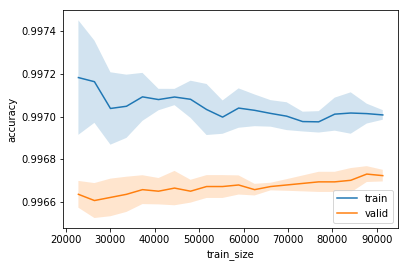

In [94]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.